# Experiment x
Only Benign Samples

## Dataset

In [2]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
ROOT_DIR = os.getcwd()
sys.path.insert(0, ROOT_DIR)

In [4]:
def train_test_split(X, y, train_test_idx):
    X_train_df = X.loc[train_test_idx["train"]]
    X_test_df = X.loc[train_test_idx["test"]]

    y_train = y.loc[train_test_idx["train"]]
    y_test = y.loc[train_test_idx["test"]]

    return X_train_df, X_test_df, y_train, y_test

In [5]:
def setup_train_test_idx(
    X, last_train_time_step, last_time_step, aggregated_timestamp_column="time_step"
):
    """The aggregated_time_step_column needs to be a column with integer values, such as year, month or day"""

    split_timesteps = {}

    split_timesteps["train"] = list(range(last_train_time_step + 1))
    split_timesteps["test"] = list(range(last_train_time_step + 1, last_time_step + 1))

    train_test_idx = {}
    train_test_idx["train"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["train"])
    ].index
    train_test_idx["test"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["test"])
    ].index

    return train_test_idx

In [6]:
def combine_dataframes(df_classes, df_features, only_labeled=True):
    df_combined = pd.merge(
        df_features, df_classes, left_on="id", right_on="txId", how="left"
    )
    if only_labeled == True:
        df_combined = df_combined[df_combined["class"] != 2].reset_index(drop=True)
    df_combined.drop(columns=["txId"], inplace=True)
    return df_combined

In [7]:
def rename_classes(df_classes):
    df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)
    return df_classes

In [8]:
def rename_features(df_features):
    df_features.columns = (
        ["id", "time_step"]
        + [f"trans_feat_{i}" for i in range(93)]
        + [f"agg_feat_{i}" for i in range(72)]
    )
    return df_features

In [9]:
def import_elliptic_data_from_csvs():
    df_classes = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_classes.csv")
    )
    df_edges = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_edgelist.csv")
    )
    df_features = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_features.csv"),
        header=None,
    )
    return df_classes, df_edges, df_features

In [10]:
def load_elliptic_data(only_labeled=True, drop_node_id=True):
    df_classes, df_edges, df_features = import_elliptic_data_from_csvs()
    df_features = rename_features(df_features)
    df_classes = rename_classes(df_classes)
    df_combined = combine_dataframes(df_classes, df_features, only_labeled)

    if drop_node_id == True:
        X = df_combined.drop(columns=["id", "class"])
    else:
        X = df_combined.drop(columns="class")

    y = df_combined["class"]

    return X, y

In [11]:
def run_elliptic_preprocessing_pipeline(
    last_train_time_step, last_time_step, only_labeled=True, drop_node_id=True
):
    print(f'run_elliptic_preprocessing_pipeline {only_labeled}')
    X, y = load_elliptic_data(only_labeled, drop_node_id)
    train_test_idx = setup_train_test_idx(X, last_train_time_step, last_time_step)
    X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, train_test_idx)

    return X_train_df, X_test_df, y_train, y_test

## EFC

In [180]:
from efc import EnergyBasedFlowClassifier

In [181]:
# Elliptic data set timestep
last_time_step = 49
last_train_time_step = 34
only_labeled = True

In [182]:
X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_59021/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [183]:
#X_train_df.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [184]:
#X_test_df.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [185]:
#y_train.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [186]:
#y_test.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [187]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [188]:
df_sizes = pd.DataFrame(data=sizes, index=[0])

In [189]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [190]:
idx_abnormal = np.where(y_train == 1)[0]  # find abnormal samples indexes in the training set

In [191]:
X_train_df.drop(idx_abnormal, axis=0, inplace=True)  # remove abnormal samples from training (EFC trains with only benign instances)

In [192]:
y_train.drop(idx_abnormal, axis=0, inplace=True)  # remove the corresponding abonrmal training targets

In [193]:
sizes_1 = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [194]:
df_sizes.loc[1] = sizes_1

In [195]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587
1,43102,43102,26432,16670,26432,16670,0,26432,1083,15587


In [196]:
clf = EnergyBasedFlowClassifier(n_bins=20, cutoff_quantile=0.9, pseudocounts=0.1)

In [197]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(cutoff_quantile=0.9, n_bins=20, pseudocounts=0.1)

In [198]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

In [199]:
results_efc = 'results/efc/experiment-4'

In [200]:
# make experiments results dir if not exists
if not os.path.exists(results_efc):
    os.makedirs(results_efc)

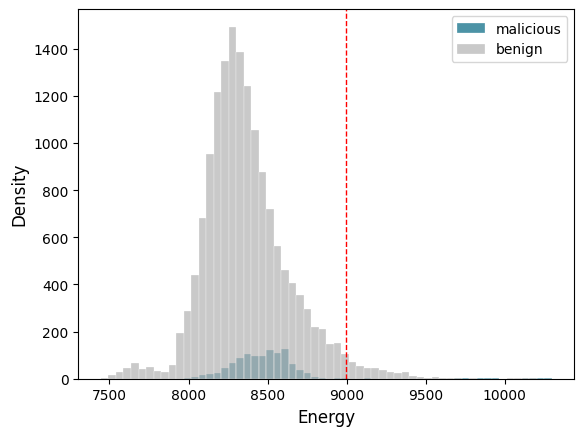

In [201]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.savefig(f'{results_efc}/1_labeled_samples.png')

In [202]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

In [203]:
def calculate_model_score(y_true, y_pred):
    metric_dict = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "f1_micro": f1_score(y_true, y_pred, average="micro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
    }
    return metric_dict

In [204]:
model_score = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

/Users/kevinaraujo/.pyenv/versions/masters/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [205]:
model_score

{'accuracy': 0.9350329934013197,
 'f1': np.float64(0.9036400947482017),
 'f1_micro': np.float64(0.9350329934013197),
 'f1_macro': np.float64(0.4832129460272189),
 'precision': np.float64(0.8742866987490324),
 'recall': np.float64(0.9350329934013197)}

In [34]:
df_efc_metrics = pd.DataFrame(data=model_score, index=[0])

In [206]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.935033,0.903640,0.935033,0.483213,0.874287,0.935033
1,0.932034,0.902364,0.932034,0.484167,0.876608,0.932034


In [207]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [208]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

In [209]:
cm = np.reshape(cm, -1).tolist()

In [210]:
cm

[0, 1083, 0, 15587]

In [211]:
confusion_matrix = {'Technique': 'All labeled samples'} | {label: val for val, label in zip(cm, labels_cm)}

In [212]:
confusion_matrix

{'Technique': 'All labeled samples',
 'True Negative': 0,
 'False positive': 1083,
 'False Negative': 0,
 'True Positive': 15587}

In [42]:
X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_59021/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [43]:
X_train_df

,time_step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29889,34,-0.172968,-0.071395,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163627,-0.169442,...,0.170195,1.266002,1.461330,1.461369,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
29890,34,-0.172924,-0.107411,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,-0.163583,-0.169398,...,-0.577099,0.534340,0.241128,0.241406,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
29891,34,-0.172897,-0.070152,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163555,-0.169371,...,-0.039047,-0.146863,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
29892,34,-0.155367,-0.081852,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.145619,-0.151686,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792


In [44]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [45]:
sizes

{'X Size': 46564,
 'y Size': 46564,
 'X_train Size': 29894,
 'X_test Size': 16670,
 'y_train Size': 29894,
 'y_test Size': 16670,
 'y_train Malicious Size': 3462,
 'y_train Bening Size': 26432,
 'y_test Malicious Size': 1083,
 'y_test Bening Size': 15587}

In [46]:
df_sizes.loc[1] = sizes

In [47]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587
1,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [48]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [49]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [50]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

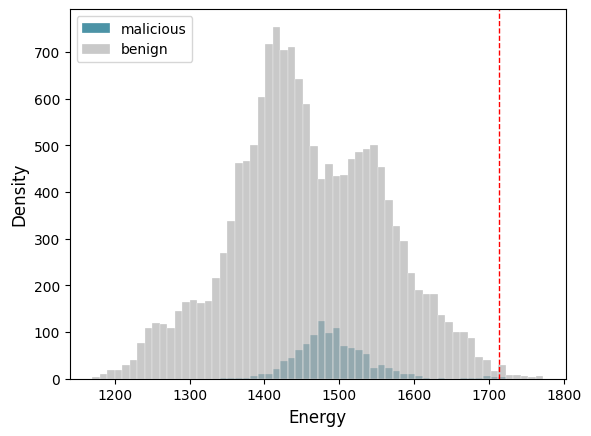

In [51]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()

In [52]:
model_score_1 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [53]:
model_score_1

{'accuracy': 0.9320335932813437,
 'f1': np.float64(0.9023642297215495),
 'f1_micro': np.float64(0.9320335932813437),
 'f1_macro': np.float64(0.4841674862120687),
 'precision': np.float64(0.8766080121321266),
 'recall': np.float64(0.9320335932813437)}

In [54]:
df_efc_metrics.loc[1] = model_score_1

In [55]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.935033,0.903640,0.935033,0.483213,0.874287,0.935033
1,0.932034,0.902364,0.932034,0.484167,0.876608,0.932034


In [56]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_59021/2457485430.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [57]:
display_side_by_side([df_sizes, df_efc_metrics], ['Sizes of X and Y, Benign and All Samples', 'Metrics'])

In [58]:
only_labeled = True

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_59021/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [59]:
idx_abnormal = np.where(y_train == 1)[0]  # find abnormal samples indexes in the training set

In [60]:
X_train_df.drop(idx_abnormal, axis=0, inplace=True)  # remove abnormal samples from training (EFC trains with only benign instances)

In [61]:
y_train.drop(idx_abnormal, axis=0, inplace=True)  # remove the corresponding abonrmal training targets

In [62]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [63]:
df_sizes_1 = pd.DataFrame(data=sizes, index=[0])

In [64]:
df_sizes_1

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,43102,43102,26432,16670,26432,16670,0,26432,1083,15587


In [65]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [66]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [67]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

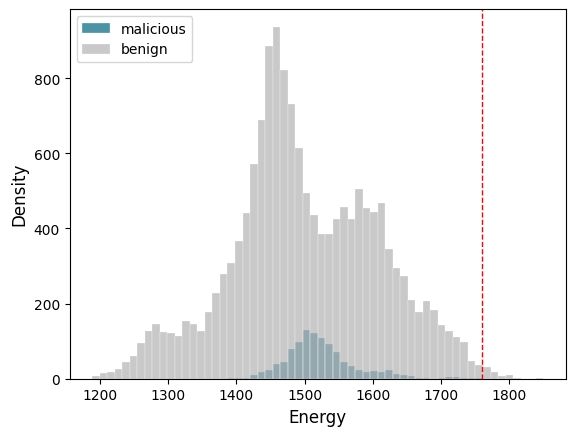

In [68]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()

In [69]:
model_score_2 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

/Users/kevinaraujo/.pyenv/versions/masters/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
model_score_2

{'accuracy': 0.9350329934013197,
 'f1': np.float64(0.9036400947482017),
 'f1_micro': np.float64(0.9350329934013197),
 'f1_macro': np.float64(0.4832129460272189),
 'precision': np.float64(0.8742866987490324),
 'recall': np.float64(0.9350329934013197)}

In [71]:
df_efc_metrics_1 = pd.DataFrame(data=model_score_2, index=[0])

In [72]:
df_efc_metrics_1

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.935033,0.90364,0.935033,0.483213,0.874287,0.935033


In [73]:
only_labeled = True

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_59021/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [74]:
results_efc = 'results/efc'

In [75]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [76]:
df_sizes_1 = pd.DataFrame(data=sizes, index=[0])

In [77]:
df_sizes_1

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [78]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [79]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [80]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

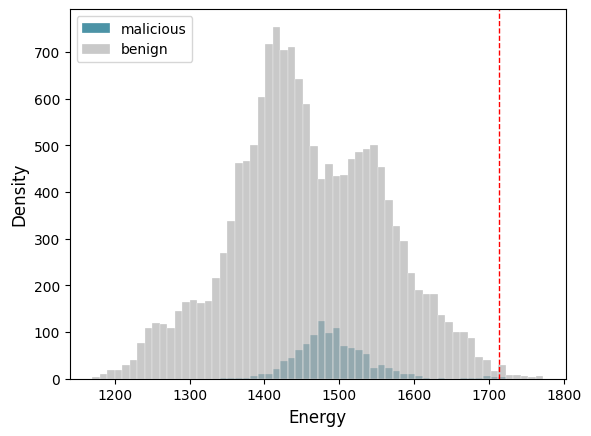

In [81]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.savefig(f'{results_efc}/experiment_2/1_labeled_samples.png')

In [82]:
model_score_3 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [83]:
df_efc_metrics_1 = pd.DataFrame(data=model_score_3, index=[0])

In [84]:
df_efc_metrics_1

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.932034,0.902364,0.932034,0.484167,0.876608,0.932034


In [85]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [86]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

TypeError: 'dict' object is not callable

In [ ]:
cm = np.reshape(cm, -1).tolist()

In [ ]:
cm

In [ ]:
confusion_matrix = {'Technique': 'All labeled samples'} | {label: val for val, label in zip(cm, labels_cm)}

In [ ]:
confusion_matrix

In [ ]:
f1_macro_weighted = f1_score(y_true=y_test.values, y_pred=y_pred, average="weighted")

In [ ]:
f1_macro_weighted

In [ ]:
f1_micro = f1_score(y_true=y_test.values, y_pred=y_pred, average="micro")

In [ ]:
f1_micro

In [ ]:
f1_macro = f1_score(y_true=y_test.values, y_pred=y_pred, average="macro")

In [ ]:
f1_macro

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

In [ ]:
cm = np.reshape(cm, -1).tolist()

In [ ]:
cm

In [ ]:
confusion_matrix_1 = {'Technique': 'All labeled samples'} | {label: val for val, label in zip(cm, labels_cm)}

In [ ]:
confusion_matrix_1

In [ ]:
f1_pos_label = f1_score(y_true=y_test.values, y_pred=y_pred, pos_label=0)

In [ ]:
f1_pos_label

In [ ]:
precision = precision_score(y_test.values, y_pred)
recall = recall_score(y_test.values, y_pred)
f1score = f1_score(y_pred, y_test.values)

In [ ]:
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

In [ ]:
malicious_test = np.where(y_test == 1)[0]

In [ ]:
len(malicious_test)

In [ ]:
malicious_pred = np.where(y_pred == 1)[0]

In [ ]:
len(malicious_pred)

In [ ]:
benign_test = np.where(y_test == 0)[0]

In [ ]:
len(benign_test)

In [ ]:
benign_pred = np.where(y_pred == 0)[0]

In [ ]:
len(benign_pred)

In [ ]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [ ]:
y_test.values

In [ ]:
y_pred

In [ ]:
clf.estimators_

In [ ]:
pfbeta_val = pfbeta(labels=y_test.values, predictions=y_pred, beta=0.5)

In [ ]:
pfbeta_val